In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.ticker import MultipleLocator
from scipy.io import readsav

from matplotlib import animation, rc
from IPython.display import HTML

import sys
sys.path.append("../")
from iris2gauss import fit2gauss

In [2]:
path = '/Users/WilliamHenryAshfieldIV/dat/iris/'
filename = 'raster_data.sav'
fn = path+filename

In [3]:
ro = readsav(fn,verbose=False,python_dict=False)

In [4]:
tm = np.array(ro.d['TIME'][0])
ro.d['TIME_CCSDS'][0][0]

b'2014-10-25T14:58:28.730'

In [5]:
sttime = 53908 # observation start time in sec.
tm += sttime

In [6]:
import datetime
import matplotlib.dates as date

In [8]:
dts = np.empty(len(tm), dtype = '<U15')
for i in range (0,len(tm)):
    dts[i] = str(datetime.timedelta(seconds=tm[i],milliseconds=3))

In [9]:
dts[0]

'14:58:28.173000'

In [10]:
tmp = np.array([datetime.datetime for x in range(len(tm))])
for i in range(0,len(tm)):
    tmp[i]=datetime.datetime.strptime(dts[i],'%H:%M:%S.%f')
tm_d = date.date2num(tmp)

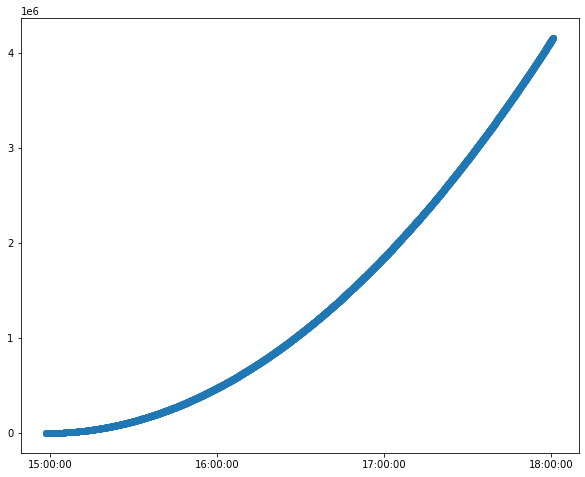

In [11]:
ty = np.arange(0,len(tm))
fig, ax = plt.subplots(figsize=(10,8))
ax.plot_date(tm_d,ty**2)
ax.xaxis.set_major_locator(date.HourLocator())
ax.xaxis.set_major_formatter(date.DateFormatter('%H:%M:%S'))

In [12]:
Int = ro.d['INT'][0]
wvl = ro.d['WVL'][0]
err = ro.d['ERR'][0]

data = Int[69,:,:] # raster px=69, the one we want.
error = err[69,:,:]

# trim:
jj = np.where((wvl > 1402) & (wvl < 1405))[0]
data = data[:,jj]
error = error[:,jj]
wvl = wvl[jj]

In [13]:
Int.shape

(387, 2040, 197)

In [14]:
wvl[0]

1402.014467867996

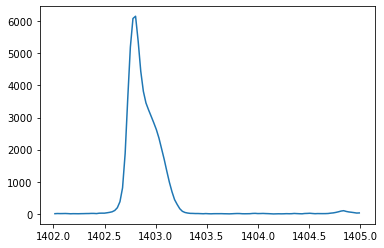

In [15]:
plt.plot(wvl,data[1426,:])

In [16]:
it = np.arange(1000,1600) # subrange of time (in index) to fit
N = len(it)

In [17]:
v_r = np.zeros(N)
v_b = np.zeros(N)
amp = np.zeros(N)

for i in range(0,N):
    
    t_i = it[i]
    dt = data[t_i,:]
    er = error[t_i,:]
        
    res = fit2gauss(wvl,dt,er,chi_thr=250.)
    a2g = res["a2g"] # extract fit parameters
    a1g = res["a1g"]

    #calculate Doppler velocities and wavelengths
    line = 1402.77
    c = 300.
    freq = c/line*1e3

    amp[i] = a1g[0]

    if a2g[1] < a2g[4]:
        v_b[i] = (a2g[1]-line)/line*3e5 # in km/s
        v_r[i] = (a2g[4]-line)/line*3e5
    else:
        v_r[i] = (a2g[1]-line)/line*3e5 # in km/s
        v_b[i] = (a2g[4]-line)/line*3e5

../iris2gauss.py:12: RuntimeWarning: divide by zero encountered in true_divide
  ef1 = np.exp( -0.5*( (x-a[1])/a[2] )**2 )
/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
../iris2gauss.py:93: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(m2)
../iris2gauss.py:35: RuntimeWarning: invalid value encountered in double_scalars
  s = mvec[3]/mvec[2]**(1.5) # the skewness
../iris2gauss.py:38: RuntimeWarning: invalid value encountered in sqrt
  dv = np.sqrt(mvec[2]/f/(1.0-f)) # estimate of separation  v_red - v_blue
../iris2gauss.py:43: RuntimeWarning: invalid value encountered in sqrt
  a0 = dx*mvec[0]/(np.sqrt(2*np.pi*mvec[2]))


In [18]:
tmp[1420]
tmp[1430]

datetime.datetime(1900, 1, 1, 17, 6, 19, 813000)

(-25566.287890243057, -25566.287270682868)

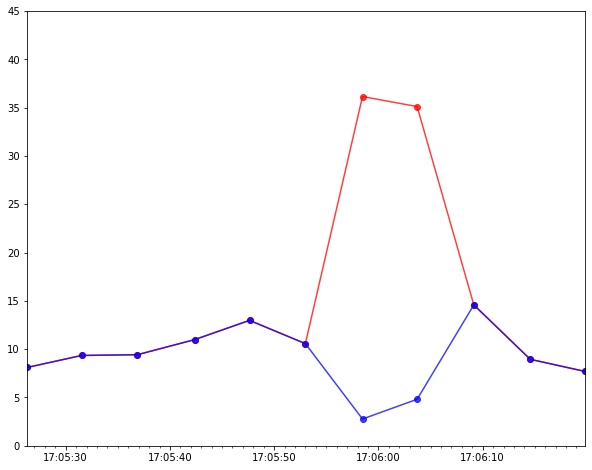

In [19]:
#plt.figure(figsize=(14,8))
#plt.plot(it,v_r,'r',alpha=0.75,marker='o')
#plt.plot(it,v_b,'b',alpha=0.75,marker='o')
#plt.ylim(0,60)
#plt.xlim(1420,1430)

fig, ax = plt.subplots(figsize=(10,8))
ax.plot_date(tm_d[it],v_r,'r',alpha=0.75,marker='o')
ax.plot_date(tm_d[it],v_b,'b',alpha=0.75,marker='o')
#ax.xaxis.set_major_locator(date.MinuteLocator())
#ax.xaxis.set_major_locator(tmp[1420:1430])
ax.xaxis.set_major_formatter(date.DateFormatter('%H:%M:%S'))
ax.xaxis.set_minor_locator(date.SecondLocator())
#ax.xaxis.set_minor_formatter(date.DateFormatter('0.%f'))
ax.set_ylim(0,45)
ax.set_xlim([tmp[1420], tmp[1430]])

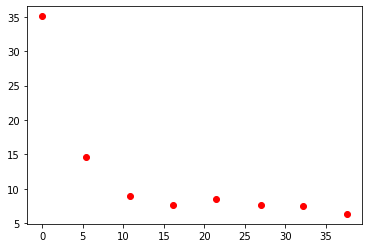

In [20]:
tm -= sttime
stm = tm[1427:1435]
stm -= stm[0] # put time array into seconds, starting at max velocity, for fitting.
vr = v_r[427:435]
plt.plot(stm,vr,'r' 'o')

In [21]:
from scipy.optimize import curve_fit
def u0_fit(t, *a):
    return a[0]/(1+t/a[1])

In [34]:
a0= [35,15]
popt, pcov = curve_fit(u0_fit, stm, vr,p0=a0)
vr_fit = u0_fit(stm,*popt)

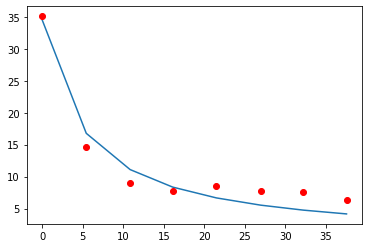

In [40]:
plt.plot(stm,vr_fit,'-')
plt.plot(stm,vr,'r' 'o')

In [41]:
vr_iris = vr
%store vr_fit
%store vr_iris
%store stm

Stored 'vr_fit' (ndarray)
Stored 'vr_iris' (ndarray)
Stored 'stm' (ndarray)


In [24]:
H = 0.6*popt[0]*popt[1]
print('H = ', H)
print('tau = ',popt[1])

H =  106.45466696761606
tau =  5.137937459823468


In [25]:
stm_d = tm_d[1427:1435]

In [26]:
stm_d

array([-25566.28745703, -25566.28739406, -25566.28733145, -25566.28727068,
       -25566.2872083 , -25566.28714522, -25566.28708446, -25566.28702253])

(0.0, 45.0)

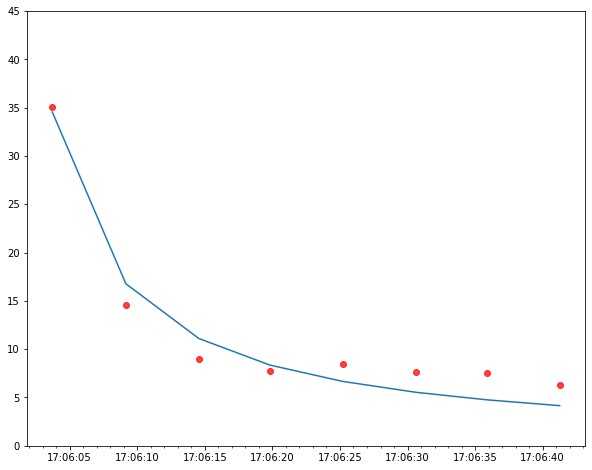

In [30]:
fig, ax = plt.subplots(figsize=(10,8))
ax.plot_date(stm_d,vr,'r' 'o',alpha=0.75)
ax.plot_date(stm_d,u0_fit(stm,*popt),'-')
#ax.plot_date(stm_d,vb,'b',alpha=0.75,marker='o')
#ax.xaxis.set_major_locator(date.MinuteLocator())
#ax.xaxis.set_major_locator(tmp[1420:1430])
ax.xaxis.set_major_formatter(date.DateFormatter('%H:%M:%S'))
ax.xaxis.set_minor_locator(date.SecondLocator())
#ax.xaxis.set_minor_formatter(date.DateFormatter('0.%f'))
ax.set_ylim(0,45)
#ax.set_xlim([tmp[1420], tmp[1430]])

#plt.plot(stm,u0_fit(stm,*popt),'-')
#plt.plot(stm,vr,'r' 'o')

In [31]:
stm_d[0]

-25566.287457025464